HRNet이 384x288이지만, 지금 영상이 고화질이다보니 대부분 사람 크기가 그 두배 좀 안됨.
그러므로 사람을 그 두배인 768x576크기로 만들자.
하지만 가급적이면 비율이 맞도록

---

## 라이브러리 로딩

In [162]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [2]:
import math
import os
import random
import shutil
import json
import logging
import sys
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm

import utils
import networks

---

## 하이퍼 파라미터

In [3]:
RESULT_DIR = Path("results/box학습")

In [4]:
LR = 1e-4  # transfer learning이니깐 좀 작게 주는게 좋을 것 같아서 1e-4
BATCH_SIZE = 10
START_EPOCH = 1

In [5]:
n = datetime.now()
UID = f"{n.year:04d}{n.month:02d}{n.day:02d}-{n.hour:02d}{n.minute:02d}{n.second:02d}"
SEED = 20210309

In [6]:
utils.seed_everything(SEED, deterministic=False)

RESULT_DIR.mkdir(parents=True, exist_ok=True)
log = utils.CustomLogger(RESULT_DIR / f"log_{UID}.log", "a")
log.info("학습 시작")

[2021-03-10 08:55:32  INFO] 학습 시작


---

## 데이터 로딩

시간이 많지 않으니 box는 CrossValidation하지 않고, 대신 fold만 10개로 나눠줌

In [7]:
train_imgs_ori = np.array(sorted(list(Path("data/ori/train_imgs/").glob("*.jpg"))))
test_imgs = np.array(sorted(list(Path("data/ori/test_imgs/").glob("*.jpg"))))
train_df = pd.read_csv("data/ori/train_df.csv")

In [8]:
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

In [9]:
train_idx, valid_idx = next(kf.split(train_imgs_ori).__iter__())

In [10]:
train_imgs = train_imgs_ori[train_idx]
valid_imgs = train_imgs_ori[valid_idx]

In [11]:
dfn = train_df.to_numpy()
train_keypoints = dfn[train_idx, 1:].reshape(len(train_idx), -1, 2)
valid_keypoints = dfn[valid_idx, 1:].reshape(len(valid_idx), -1, 2)

In [12]:
log.info(f"train: {train_keypoints.shape}, valid: {valid_keypoints.shape}, test: {len(test_imgs)}")

[2021-03-10 08:55:32  INFO] train: (3775, 24, 2), valid: (420, 24, 2), test: 1600


train 3397, valid 378개, test 1600개

In [13]:
class ImageDataset(Dataset):
    def __init__(self, files, keypoints=None, padding=40):
        super().__init__()
        self.files = files
        self.keypoints = keypoints
        self.padding = padding

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]
        img = imageio.imread(f)
        x = torch.as_tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0

        if self.keypoints is not None:
            keypoints = self.keypoints[idx]
            xmin = keypoints[:, 0].min() - self.padding
            xmax = keypoints[:, 0].max() + self.padding
            ymin = keypoints[:, 1].min() - self.padding
            ymax = keypoints[:, 1].max() + self.padding
            target = {
                "labels": torch.tensor([1], dtype=torch.int64),
                "boxes": torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32),
            }
            return x, target
        return x

In [14]:
ds_train = ImageDataset(train_imgs, train_keypoints)
ds_valid = ImageDataset(valid_imgs, valid_keypoints)
ds_test = ImageDataset(test_imgs)
ds_total = utils.ChainDataset(ds_train, ds_valid)

In [15]:
print("data example:\r\n", str(ds_train[0][0]), "\r\n", str(ds_train[0][1]))

data example:
 tensor([[[0.5686, 0.5647, 0.4863,  ..., 0.5529, 0.5529, 0.5529],
         [0.5216, 0.4392, 0.3255,  ..., 0.5490, 0.5490, 0.5490],
         [0.3725, 0.3020, 0.1804,  ..., 0.5529, 0.5529, 0.5490],
         ...,
         [0.9020, 0.9020, 0.9020,  ..., 0.6235, 0.6275, 0.6275],
         [0.9020, 0.9020, 0.9020,  ..., 0.6275, 0.6275, 0.6275],
         [0.9059, 0.9059, 0.9059,  ..., 0.6353, 0.6353, 0.6392]],

        [[0.5843, 0.5765, 0.4980,  ..., 0.5294, 0.5294, 0.5294],
         [0.5294, 0.4471, 0.3333,  ..., 0.5255, 0.5255, 0.5255],
         [0.3765, 0.3059, 0.1804,  ..., 0.5294, 0.5294, 0.5255],
         ...,
         [0.8392, 0.8392, 0.8392,  ..., 0.6667, 0.6706, 0.6706],
         [0.8392, 0.8392, 0.8392,  ..., 0.6706, 0.6706, 0.6706],
         [0.8431, 0.8431, 0.8431,  ..., 0.6784, 0.6784, 0.6824]],

        [[0.4941, 0.4941, 0.4235,  ..., 0.4039, 0.4039, 0.4039],
         [0.4745, 0.3922, 0.2824,  ..., 0.4000, 0.4000, 0.4000],
         [0.3569, 0.2863, 0.1725,  ..., 0.4

In [128]:
collate_fn = lambda x: tuple(zip(*x))
dl_kwargs = dict(batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
dl_train = DataLoader(ds_train, **dl_kwargs, shuffle=True, collate_fn=collate_fn)
dl_valid = DataLoader(ds_valid, **dl_kwargs, shuffle=False, collate_fn=collate_fn)
dl_test = DataLoader(ds_test, **dl_kwargs, shuffle=False)
dl_total = DataLoader(ds_total, **dl_kwargs, shuffle=True, collate_fn=collate_fn)

---

## 학습

In [17]:
box_model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False).cuda()

In [18]:
optimizer = optim.AdamW(box_model.parameters(), lr=LR)

In [19]:
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

In [20]:
def train_loop(dl: DataLoader):
    torch.cuda.empty_cache()
    box_model.train()

    meanloss = utils.AverageMeter()
    with tqdm(total=len(dl.dataset), ncols=100, leave=False, file=sys.stdout) as t:
        for xs, ys in dl:
            xs_ = [x.cuda(non_blocking=True) for x in xs]
            ys_ = [{k: v.cuda(non_blocking=True) for k, v in y.items()} for y in ys]
            losses = box_model(xs_, ys_)
            loss = sum(loss for loss in losses.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            meanloss.update(loss.item())
            t.set_postfix_str(f"loss: {loss.item():.6f}", refresh=False)
            t.update(len(xs))

    return meanloss()

In [21]:
@torch.no_grad()
def valid_loop(dl: DataLoader):
    torch.cuda.empty_cache()
    box_model.train()

    meanloss = utils.AverageMeter()
    with tqdm(total=len(dl.dataset), ncols=100, leave=False, file=sys.stdout) as t:
        for xs, ys in dl:
            xs_ = [x.cuda(non_blocking=True) for x in xs]
            ys_ = [{k: v.cuda(non_blocking=True) for k, v in y.items()} for y in ys]
            losses = box_model(xs_, ys_)
            loss = sum(loss for loss in losses.values())

            meanloss.update(loss.item())
            t.set_postfix_str(f"val_loss: {loss.item():.6f}", refresh=False)
            t.update(len(xs))

    return meanloss()

In [ ]:
best_loss = math.inf
early_stop_cnt = 0

for epoch in range(START_EPOCH, 999):
    tloss = train_loop(dl_train)
    vloss = valid_loop(dl_valid)
    
    # Logging
    log.info(f'Epoch: {epoch:03d}, loss: {tloss:.6f} ; {vloss:.6f}')
    scheduler.step(vloss)
    
    # Earlystop
    if vloss < best_loss:
        best_loss = vloss
        early_stop_cnt = 0
        
        torch.save({
            'model': box_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
        }, RESULT_DIR/f'ckpt-{UID}.pth')
    elif early_stop_cnt >= 20:
        log.info(f'Stop training at epoch {epoch}.')
        break
    else:
        early_stop_cnt +=1

best ckpt 불러와서 ds_train, ds_valid 합쳐서 2epoch정도 더 학습하기

In [22]:
# ckpt = torch.load(RESULT_DIR / f"ckpt-{UID}.pth")
ckpt = torch.load(RESULT_DIR / f"ckpt-20210309-224040.pth")
box_model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [38]:
best_loss = math.inf

for epoch in range(1, 5):
    loss = train_loop(dl_total)

    log.info(f"Additional Training Epoch: {epoch:03d}, loss: {loss:.6f}")
    if loss < best_loss:
        best_loss = loss
        torch.save(
            {
                "model": box_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
            },
            RESULT_DIR / f"ckpt-additional_training-20210309-224040.pth",
        )

[2021-03-10 09:13:34  INFO] Additional Training Epoch: 001, loss: 0.005700                 
[2021-03-10 09:19:38  INFO] Additional Training Epoch: 002, loss: 0.005306                 
[2021-03-10 09:25:43  INFO] Additional Training Epoch: 003, loss: 0.005104                 
[2021-03-10 09:31:48  INFO] Additional Training Epoch: 004, loss: 0.005092                 


---

TODO: HRNet이 고정된 사이즈의 이미지만을 받는지 확인

In [72]:
def cut_box(im, box):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im)
    plt.subplot(1, 2, 2)
    plt.imshow(im[box[1] : box[3], box[0] : box[2]])
    plt.tight_layout()
    plt.show()

In [39]:
box_model.eval()
torch.set_grad_enabled(False)
pass

In [42]:
im = imageio.imread("data/ori/train_imgs/001-1-1-01-Z17_A-0000001.jpg")
x = torch.tensor(im, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).cuda(non_blocking=True) / 255.0
x.shape

torch.Size([1, 3, 1080, 1920])

In [47]:
box = box_model(x)[0]["boxes"]

In [53]:
p = box.cpu().type(torch.int64).tolist()[0]

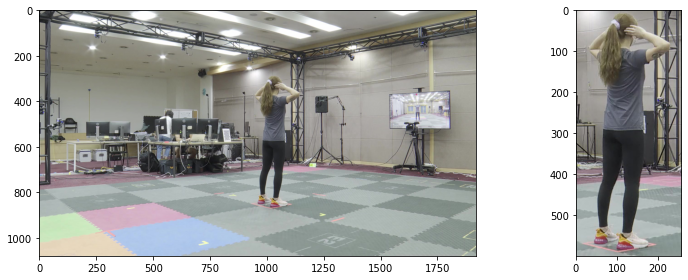

In [73]:
cut_box(im, p)

In [82]:
im = imageio.imread("data/ori/test_imgs/713-3-5-35-Z94_A-0000023.jpg")
x = torch.tensor(im, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).cuda(non_blocking=True) / 255.0
x.shape

torch.Size([1, 3, 1080, 1920])

In [83]:
box = box_model(x)[0]["boxes"]

In [84]:
p = box.cpu().type(torch.int64).tolist()[0]

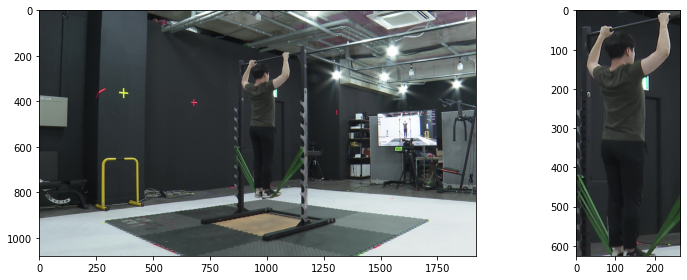

In [85]:
cut_box(im, p)

---

## 모든 이미지를 자르기

In [88]:
ckpt = torch.load("results/box학습/ckpt-additional_training-20210309-224040.pth")
box_model.load_state_dict(ckpt["model"])
box_model.eval()
torch.set_grad_enabled(False)
pass

In [86]:
out_dir = Path("data/box2")
out_dir.mkdir(parents=True, exist_ok=True)

In [87]:
out_train = out_dir / "train_imgs"
out_test = out_dir / "test_imgs"
out_train.mkdir(parents=True, exist_ok=True)
out_test.mkdir(parents=True, exist_ok=True)

In [173]:
train_imgs = sorted(list((Path("data/ori/train_imgs/").glob("*.jpg"))))
test_imgs = sorted(list(Path("data/ori/test_imgs/").glob("*.jpg")))
ds_train = ImageDataset(train_imgs)
ds_test = ImageDataset(test_imgs)
dl_train = DataLoader(ds_train, **dl_kwargs, shuffle=False)
dl_test = DataLoader(ds_test, **dl_kwargs, shuffle=False)

In [174]:
offset_data = {"train": [], "test": []}

In [175]:
torch.cuda.empty_cache()
i = 0
with tqdm(total=len(dl_train_imgs.dataset), ncols=100, file=sys.stdout) as t:
    for xs in dl_train:
        xs_ = xs.cuda()
        outs_ = box_model(xs_)
        for x, out_ in zip(xs, outs_):
            box = out_["boxes"][0].cpu().type(torch.int64).cpu().numpy()
            im = (x.permute(1, 2, 0) * 255.0).type(torch.uint8).numpy()
            im_out = im[box[1] : box[3], box[0] : box[2]]

            fname = train_imgs[i].name
            out_path = out_train / fname
            imageio.imwrite(out_path, im_out)

            offset_data["train"].append({"image": fname, "boxes": box.tolist()})
            i += 1
            t.set_postfix_str(fname)
            t.update()

100%|████████████████████████████| 4195/4195 [03:20<00:00, 20.93it/s, 642-2-4-31-Z148_E-0000031.jpg]


In [177]:
torch.cuda.empty_cache()
i = 0
with tqdm(total=len(dl_test_imgs.dataset), ncols=100, file=sys.stdout) as t:
    for xs in dl_test:
        xs_ = xs.cuda()
        outs_ = box_model(xs_)
        for x, out_ in zip(xs, outs_):
            box = out_["boxes"][0].cpu().type(torch.int64).cpu().numpy()
            im = (x.permute(1, 2, 0) * 255.0).type(torch.uint8).numpy()
            im_out = im[box[1] : box[3], box[0] : box[2]]

            fname = test_imgs[i].name
            out_path = out_test / fname
            imageio.imwrite(out_path, im_out)

            offset_data["test"].append({"image": fname, "boxes": box.tolist()})
            i += 1
            t.set_postfix_str(fname)
            t.update()

100%|█████████████████████████████| 1600/1600 [01:15<00:00, 21.25it/s, 786-3-5-41-Z94_E-0000031.jpg]


In [179]:
with open("data/box2/offset.json", "w") as f:
    json.dump(offset_data, f)